<h1 style="text-align: center; vertical-align: middle;">Numerical Methods in Accelerator Physics</h1>
<h2 style="text-align: center; vertical-align: middle;">Python examples -- Week 8</h2>

<h2>Run this first!</h2>

Imports and modules:

In [1]:
from config8 import (np, plt, sys, Madx, interp1d, PyNAFF, pysixtrack, elements, M_drift, M_dip_x, M_dip_y, M_quad_x, M_quad_y, track, track_sext_4D)
%matplotlib inline

<h2>Twiss parameters</h2>
<h3>Compute Twiss parameters</h3>

Use the Methodical Accelerator Design (`MAD-X`) code to compute the optical Twiss function (install `cpymad` via pip):

In [2]:
madx = Madx(stdout=sys.stdout)


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.03  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2024.04.25               +
  + Execution date: 2024.12.11 12:41:32      +
  ++++++++++++++++++++++++++++++++++++++++++++


Define the following periodic beam line of $10$m length:
- focusing quadrupole centred at $3$m (strength $k=0.1$m$^{-2}$ and length $L=0.6$m)
- dipole sector bend centred at $5$m (bending angle $\theta=\pi/8$ and length $L=0.6$m)
- defocusing quadrupole centred at $7$m (strength $k=-0.5$m$^{-2}$ and length $L=0.4$m)

In [3]:
madx.input('''
k1l_f := 0.1 * 0.6; // inverse focal length qf
k1l_d := -0.5 * 0.4; // inverse focal length qd

qf: quadrupole, l = 0.6, k1 := k1l_f / 0.6;
qd: quadrupole, l = 0.4, k1 := k1l_d / 0.4;
dip: sbend, l = 0.6, angle := pi / 8;

seq1: sequence, l = 10;
qf, at = 3;
dip, at = 5;
qd, at = 7;
endsequence;
''')

True

In [4]:
madx.command.beam(particle='proton', energy=1) # energy is in GeV!
madx.use(sequence='seq1')

# output the Twiss parameters every 0.1m
madx.command.select(flag="interpolate", sequence="seq1", step=0.1)

True

Now we compute the periodic solution to the Hill equation (in terms of the Twiss paremters):

In [5]:
twiss = madx.twiss();

enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
                10                 -0      0.09572878063        3.232054955 

                q1                dq1            betxmax              dxmax 
      0.2393933525      -0.4979445041        11.70243519        7.345182369 

             dxrms             xcomax             xcorms                 q2 
       6.588466214                  0                  0       0.2224798695 

               dq2            betymax              dymax              dyrms 
     -0.1070464578        11.39223223                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            

Let us investigate the optical functions along this periodic beam line: (red areas mark quadrupoles, gray areas mark dipoles)

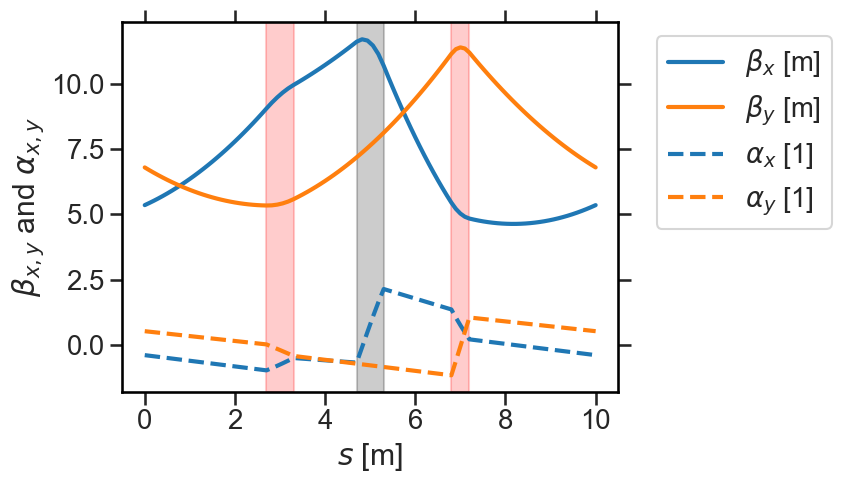

In [6]:
plt.plot(twiss['s'], twiss['betx'], label=r'$\beta_x$ [m]')
plt.plot(twiss['s'], twiss['bety'], label=r'$\beta_y$ [m]')
plt.plot(twiss['s'], twiss['alfx'], label=r'$\alpha_x$ [1]', c='C0', ls='--')
plt.plot(twiss['s'], twiss['alfy'], label=r'$\alpha_y$ [1]', c='C1', ls='--')

ylim = plt.ylim()
plt.fill_betweenx(ylim, 3-0.3, 3+0.3, color='red', alpha=0.2)
plt.fill_betweenx(ylim, 7-0.2, 7+0.2, color='red', alpha=0.2)
plt.fill_betweenx(ylim, 5-0.3, 5+0.3, color='black', alpha=0.2)
plt.ylim(ylim)

plt.xlabel('$s$ [m]')
plt.ylabel(r'$\beta_{x,y}$ and $\alpha_{x,y}$')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1));

$\implies$ periodic functions, right values at $s=10$m are equal to left values at $s=0$m!<br />
$\implies$ $\beta_{x,y}$ functions change sign of gradient at locations of the quadrupoles!<br />
$\implies$ Dipole affects horizontal plane due to dispersion!

<h3>Compare tracking with Twiss and betatron matrices</h3>

We provide interpolation functions for any position $s$ given the `MAD-X` computed Twiss table $s-\beta_{x,y}-\alpha_{x,y}-\psi_{x,y}$:

In [7]:
beta_x = interp1d(twiss['s'], twiss['betx'], kind='linear')
alpha_x = interp1d(twiss['s'], twiss['alfx'], kind='linear')
psi_x = interp1d(twiss['s'], 2 * np.pi * twiss['mux'], kind='linear')

Define the Floquet transformation matrix and the rotation matrix for the Twiss transport matrix:

In [8]:
def F(beta, alpha):
    '''Floquet transformation matrix to normalized phase space.'''
    return np.array([
        [1 / np.sqrt(beta), 0],
        [alpha / np.sqrt(beta), np.sqrt(beta)]
    ])

def R(angle):
    '''Rotation matrix.'''
    return np.array([
        [np.cos(angle), np.sin(angle)],
        [-np.sin(angle), np.cos(angle)]
    ])

def M_tw(beta0, alpha0, beta1, alpha1, delta_psi):
    '''Transport matrix with Twiss parameters from index 0 to 1.'''
    F0 = F(beta0, alpha0)
    F1 = F(beta1, alpha1),
    F1inv = np.linalg.inv(F1)
    Rot = R(delta_psi)
    return F1inv.dot(Rot.dot(F0))

Prepare the tracking of a particle along this periodic beam line: once with betatron matrices from each element, once with the Twiss matrix!

In [9]:
# path length positions at edges of elements
s = [0, 3 - 0.6/2, 3 + 0.6/2, 5 - 0.6/2, 5 + 0.6/2, 7 - 0.4/2, 7 + 0.4/2, 10]
ds = np.diff(s)

In [10]:
# betatron matrices
d1 = M_drift(ds[0])
qf = M_quad_x(ds[1], 0.1)
d2 = M_drift(ds[2])
dip = M_dip_x(ds[3], 0.6 / (np.pi / 8)) # rho0 = L / angle
d3 = M_drift(ds[4])
qd = M_quad_x(ds[5], -0.5)
d4 = M_drift(ds[6])

In [11]:
# Twiss transport matrix
def M_tw_s0to1_x(s0, s1):
    '''Twiss matrix from s0 to s1 (evaluating Twiss parameters at these points!).'''
    return M_tw(
        beta_x(s0), alpha_x(s0),
        beta_x(s1), alpha_x(s1),
        psi_x(s1) - psi_x(s0)
    )[0]

The initial horizontal coordinates of the particles at $s=0$m:

In [12]:
x_ini = 0.02
xp_ini = 0.01

Some plotting helper functions:

In [13]:
def scatter(s, x, label=None):
    plt.scatter([s], [x], c='red', s=30, marker='D', label=label)

def scatter_tw(s, x, label=None):
    plt.scatter([s], [x], c='cyan', s=40, marker='.', label=label)

Go for the tracking!

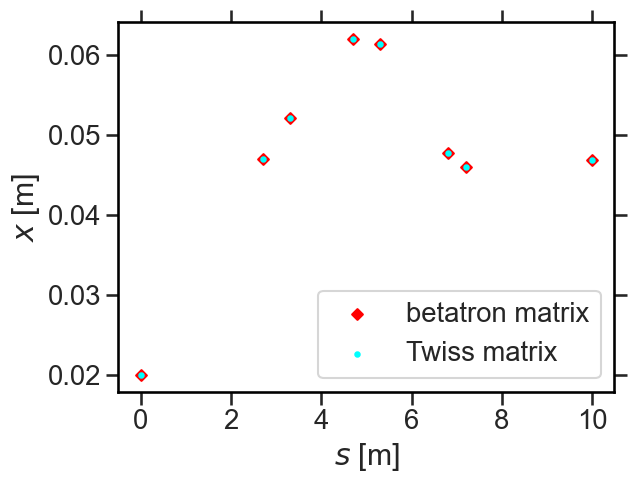

In [14]:
# track with betatron matrices from one element to the next:
scatter(0, x_ini, label='betatron matrix')

x, xp = track(d1, x_ini, xp_ini)
scatter(s[1], x)

x, xp = track(qf, x, xp)
scatter(s[2], x)

x, xp = track(d2, x, xp)
scatter(s[3], x)

x, xp = track(dip, x, xp)
scatter(s[4], x)

x, xp = track(d3, x, xp)
scatter(s[5], x)

x, xp = track(qd, x, xp)
scatter(s[6], x)

x, xp = track(d4, x, xp)
scatter(s[7], x)

# track with the Twiss transport matrix
scatter_tw(0, x_ini, label='Twiss matrix')
xt, xpt = x_ini, xp_ini
for i in range(len(s) - 1):
    M_tw_x = M_tw_s0to1_x(s[i], s[i + 1])
    xt, xpt = track(M_tw_x, xt, xpt)
    scatter_tw(s[i + 1], xt)

plt.xlabel('$s$ [m]')
plt.ylabel('$x$ [m]')
plt.legend(loc='lower right');

$\implies$ the transfer maps via the Twiss parameters $\beta_x(s)$, $\alpha_x(s)$, $\gamma_x(s)$ are identical to the element-by-element betatron matrices from the previous lecture! Both correctly describe the solution to the equation of motion (Hill differential equation!).<br />
$\implies$ the advantage with $\mathcal{M}_\mathrm{tw}$: only require one single matrix to describe solution at any location $s$! (Need to determine the optics functions / Twiss parameters before!)<br />
$\implies$ matrices are not identical in case of an unstable lattice.

<h3>Determine the Tune from tracking and compare to computed phase advance</h3>

Let us track a particle with the compiled betatron matrix for a number of periods. We can determine the tune via Discrete Frequency Analysis (using NAFF) and then compare to the phase advance computed via the Twiss matrix approach:

In [15]:
M_period = qf.dot(d1)
M_period = d2.dot(M_period)
M_period = dip.dot(M_period)
M_period = d3.dot(M_period)
M_period = qd.dot(M_period)
M_period = d4.dot(M_period)

We need to record the oscillation for a useful number of turns:

In [16]:
nperiods = 128

In [17]:
rec_x = np.zeros(nperiods, dtype=float)
rec_x[0] = x_ini

Tracking:

In [18]:
x, xp = x_ini, xp_ini
for i in range(1, nperiods):
    x, xp = track(M_period, x, xp)
    rec_x[i] = x

The horizontal motion at this location looks as follows:

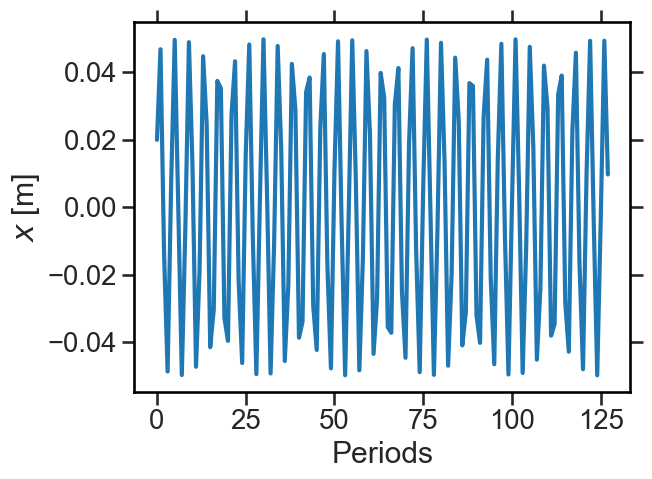

In [19]:
plt.plot(rec_x)
plt.xlabel('Periods')
plt.ylabel('$x$ [m]');

We determine the tune via the `PyNAFF` library which implements the Numerical Analysis of Fundamental Frequencies algorithm:

In [20]:
tune = PyNAFF.naff(rec_x, turns = nperiods, nterms = 1)[0, 1]
tune

0.239334575934871

$\implies$ this is the tune of the particle (number of oscillations per period) measured via tracking data!

Now what about the phase advance from the full-period transfer matrix, $2 \cos(\Phi_x)=\mathrm{Tr}(\mathcal{M})$?

In [21]:
trace = np.matrix.trace(M_period)

np.arccos(trace / 2)

1.5041527952010787

Convert from phase advance to tune units by dividing by $2\pi$:

In [22]:
np.arccos(trace / 2) / (2 * np.pi)

0.23939335252174299

$\implies$ the particle follows the same frequency as determined via the Twiss matrix approach!

This was also computed by `MAD-X`:

In [23]:
twiss.summary['q1']

0.2393933525

<h3>Exercise: Periodic transport matrices</h3>

Consider the following numerical (horizontal) transport matrices, each for a full period of a lattice.

<p style="color:#e6541a;">Can you determine:</p>

<p style="color:#e6541a;">
a) whether they are valid transport matrices (symplecticity)?<br />
b) whether they provide stable transport?<br />
c) the covered phase advance $\Phi_x$ per lattice period (and the tune $Q_x=\Phi_x\,/\,2\pi$)?<br />
d) the local Twiss parameters $\beta_x, \alpha_x$?
</p>

<p style="color:#e6541a;">
How do the eigenvalues represent stability and phase advance? (check absolute values and complex phases, picture on the unit circle)</p>

<i>Hint: you might need the following functions for a given matrix `M`:</i>

- determinant: `np.linalg.det(M)`
- trace: `np.matrix.trace(M)`
- eigenvalues: `np.linalg.eigvals(M)`
- arccos: `np.arccos(...)`
- sin: `np.sin(...)`
- absolute value: `np.abs(...)`
- phase $\phi$ (radiant units) from complex number $e^{i\phi}$: `np.angle(...)`
- matrix multiplication $M_1\cdot M_2$: `np.dot(M1, M2)` or `M1.dot(M2)`

$$\mathcal{M}_1 = \begin{pmatrix}
    -0.03701215 &  0.19960535 \\
    -5.04003498 &  0.16259319
\end{pmatrix}$$

In [24]:
M1 = np.array([
    [-0.03701215,  0.19960535],
    [-5.04003498,  0.16259319]
])

$$\mathcal{M}_2 = \begin{pmatrix}
    0.5 &  13 \\
    -0.0961538 &  -0.5
\end{pmatrix}$$

In [25]:
M2 = np.array([
    [0.5,  13],
    [-0.09615385,  -0.5]
])

<p style="color:#e6541a;">$\implies$ what happens to particles in this lattice after a short number of lattice periods? (Investigate by applying the transport matrix repetetively.)</p>

$$\mathcal{M}_3 = \begin{pmatrix}
    0.31803855 &  22.193583 \\
    -0.1533821 &  0.93858321
\end{pmatrix}$$

$$\mathcal{M}_3 = \begin{pmatrix}
    0.31803855 &  22.193583 \\
    -0.1533821 &  0.93858321
\end{pmatrix}$$

In [26]:
M3 = np.array([
    [0.31803855,  22.193583],
    [-0.1533821,  0.93858321]
])

$$\mathcal{M}_4 = \begin{pmatrix}
    -0.75105652 &  0.69069571 \\
    -0.02118063 &  -1.31197933
\end{pmatrix}$$

In [27]:
M4 = np.array([
    [-0.75105652,  0.69069571],
    [-0.02118063, -1.31197933]
])

<h3>Solution</h3>

a) Symplecticity? $\det(\mathcal{M})=1$

In [28]:
print("det(M1)="+str(np.linalg.det(M1)))
print("det(M2)="+str(np.linalg.det(M2)))
print("det(M3)="+str(np.linalg.det(M3)))
print("det(M4)="+str(np.linalg.det(M4)))

det(M1)=1.0000000226578842
det(M2)=1.00000005
det(M3)=3.702604010227046
det(M4)=1.0000000001778289


$\implies$ Only $\mathcal{M}_3$ is not symplectic.

b) Stable transport? $1/2\cdot|\mathrm{Tr}(\mathcal{M})|\leq1$

In [31]:
print("M1: "+str(0.5*np.abs(np.matrix.trace(M1))))
print("M2: "+str(0.5*np.abs(np.matrix.trace(M2))))
print("M3: "+str(0.5*np.abs(np.matrix.trace(M3))))
print("M4: "+str(0.5*np.abs(np.matrix.trace(M4))))

M1: 0.06279052
M2: 0.0
M3: 0.62831088
M4: 1.031517925


Eigenvalues? $|\lambda|\leq1$

In [32]:
print("M1: "+str(np.abs(np.linalg.eigvals(M1))))
print("M2: "+str(np.abs(np.linalg.eigvals(M2))))
print("M3: "+str(np.abs(np.linalg.eigvals(M3))))
print("M4: "+str(np.abs(np.linalg.eigvals(M4))))

M1: [1.00000001 1.00000001]
M2: [1.00000002 1.00000002]
M3: [1.92421517 1.92421517]
M4: [0.77847795 1.2845579 ]


$\implies$ $\mathcal{M_3}$ and $\mathcal{M_4}$ unstable

c) Phase advance per lattice period? $\Phi=\arccos(1/2\cdot\mathrm{Tr}(\mathcal{M}))$

In [33]:
print("Phi1="+str(np.arccos(0.5*np.matrix.trace(M1))))
print("Phi2="+str(np.arccos(0.5*np.matrix.trace(M2))))
print("Phi3="+str(np.arccos(0.5*np.matrix.trace(M3))))
print("Phi4="+str(np.arccos(0.5*np.matrix.trace(M4))))

Phi1=1.5079644732514834
Phi2=1.5707963267948966
Phi3=0.8914162343864628
Phi4=nan


Tune?

In [34]:
print("Q1="+str(np.arccos(0.5*np.matrix.trace(M1))/(2*np.pi)))
print("Q1="+str(np.arccos(0.5*np.matrix.trace(M2))/(2*np.pi)))
print("Q1="+str(np.arccos(0.5*np.matrix.trace(M3))/(2*np.pi)))
print("Q1="+str(np.arccos(0.5*np.matrix.trace(M4))/(2*np.pi)))

Q1=0.23999999992493978
Q1=0.25
Q1=0.14187330005496912
Q1=nan


d) local Twiss parameters? $\beta_x=M_{1,2}/\sin(\Phi_x)$, $\alpha_x=(M_{1,1}-\cos(\Phi_x))/\sin(\Phi_x)$

In [35]:
print("beta1="+str(M1[0,1]/np.sin(np.arccos(0.5*np.matrix.trace(M1)))))
print("alpha1="+str((M1[0,0]-np.cos(np.arccos(0.5*np.matrix.trace(M1))))/np.sin(np.arccos(0.5*np.matrix.trace(M1)))))
print("beta2="+str(M2[0,1]/np.sin(np.arccos(0.5*np.matrix.trace(M2)))))
print("alpha2="+str((M2[0,0]-np.cos(np.arccos(0.5*np.matrix.trace(M2))))/np.sin(np.arccos(0.5*np.matrix.trace(M2)))))
print("beta3="+str(M3[0,1]/np.sin(np.arccos(0.5*np.matrix.trace(M3)))))
print("alpha3="+str((M3[0,0]-np.cos(np.arccos(0.5*np.matrix.trace(M3))))/np.sin(np.arccos(0.5*np.matrix.trace(M3)))))
print("beta4="+str(M4[0,1]/np.sin(np.arccos(0.5*np.matrix.trace(M4)))))
print("alpha4="+str((M4[0,0]-np.cos(np.arccos(0.5*np.matrix.trace(M4))))/np.sin(np.arccos(0.5*np.matrix.trace(M4)))))

beta1=0.2000000043288102
alpha1=-0.09999999715451934
beta2=13.0
alpha2=0.49999999999999994
beta3=28.52783638214871
alpha3=-0.39882691605713466
beta4=nan
alpha4=nan


Phase of Eigenvalues?

In [36]:
print("M1: "+str(np.angle(np.linalg.eigvals(M1))))
print("M2: "+str(np.angle(np.linalg.eigvals(M2))))
print("M3: "+str(np.angle(np.linalg.eigvals(M3))))
print("M4: "+str(np.angle(np.linalg.eigvals(M4))))

M1: [ 1.50796447 -1.50796447]
M2: [ 1.57079633 -1.57079633]
M3: [ 1.23816803 -1.23816803]
M4: [3.14159265 3.14159265]


$\implies$ Phase of eigenvalues is equal to phase advance if motion is bounded.

<h2>FODO cell</h2>
<h3>Computing optics of a FODO cell</h3>

Consider a $110$m long FODO cell with $3.3$m long quadrupole magnets (LHC scheme). We start with a non-bending FODO cell, i.e. the dipoles switched off. Let us determine the optical functions, again via `MAD-X`:

In [37]:
madx = Madx(stdout = sys.stdout)


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.03  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2024.04.25               +
  + Execution date: 2024.12.11 12:42:59      +
  ++++++++++++++++++++++++++++++++++++++++++++


We define the FODO cell with two quadrupoles of opposite strength, $k\cdot L=0.008\cdot3.3$m$^{-1}$, and with three dipoles in between each quadrupole. For the moment the dipoles are switched off (their bending angle $\theta=0$):

In [38]:
madx.input('''
k1l_f := 0.008 * 3.3; // inverse focal length qf
k1l_d := -0.008 * 3.3; // inverse focal length qd
theta := 0; // in LHC: 2 * pi / 1232;

qf2: quadrupole, l = 3.3 / 2, k1 := k1l_f / 3.3; // half a focusing quad
qd: quadrupole, l = 3.3, k1:= k1l_d / 3.3;
dip: sbend, l = 14.3, angle := theta;

fodo: sequence, l = 110;
qf2, at = 3.3 / 4;
dip, at = 12;
dip, at = 2 * 110 / 8;
dip, at = 110 / 2 - 12;
qd, at = 110 / 2;
dip, at = 110 / 2 + 12;
dip, at = 6 * 110 / 8;
dip, at = 110 - 12;
qf2, at = 110 - 3.3 / 4;
endsequence;
''')

True

In [39]:
madx.command.beam(particle='proton', energy=7e3) # energy is in GeV!
madx.use(sequence='fodo')

# output the Twiss parameters every 1m
madx.command.select(flag="interpolate", sequence="fodo", step=1)

True

We call the TWiss routine to compute the optics:

In [40]:
twiss = madx.twiss()

enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
               110                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
      0.2518947018      -0.3220961047        186.9084848                  0 

             dxrms             xcomax             xcorms                 q2 
                 0                  0                  0       0.2518947018 

               dq2            betymax              dymax              dyrms 
     -0.3220961047        186.4581481                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            

Save some values for this FODO cell for later:

In [41]:
madx.input('value, beam->beta;')

beam->beta         =        0.999999991 ;


True

In [42]:
qx_fodo = twiss.summary['q1']
qpx_fodo = twiss.summary['dq1'] * 0.999999991

The optics of this FODO cell looks as follows:

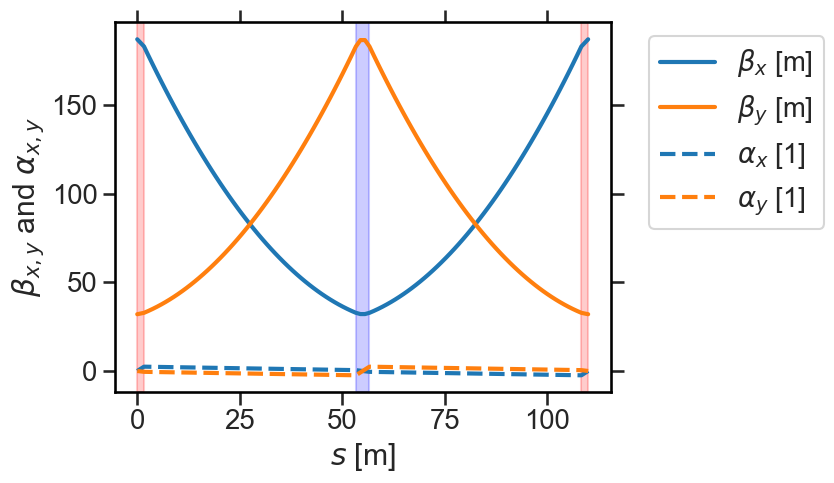

In [43]:
plt.plot(twiss['s'], twiss['betx'], label=r'$\beta_x$ [m]')
plt.plot(twiss['s'], twiss['bety'], label=r'$\beta_y$ [m]')
plt.plot(twiss['s'], twiss['alfx'], label=r'$\alpha_x$ [1]', c='C0', ls='--')
plt.plot(twiss['s'], twiss['alfy'], label=r'$\alpha_y$ [1]', c='C1', ls='--')

ylim = plt.ylim()
plt.fill_betweenx(ylim, 0, 3.3/2, color='red', alpha=0.2)
plt.fill_betweenx(ylim, 110/2 - 3.3/2, 110/2 + 3.3/2, color='blue', alpha=0.2)
plt.fill_betweenx(ylim, 110 - 3.3/2, 110, color='red', alpha=0.2)
plt.ylim(ylim)

plt.xlabel('$s$ [m]')
plt.ylabel(r'$\beta_{x,y}$ and $\alpha_{x,y}$')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1));

<h2>Off-momentum particles, dispersion & chromaticity</h2>
<h3>Computing the Dispersion function of a FODO cell</h3>

For illustration, we use again the LHC FODO cell, but now we switch on the dipole magnets:

In [44]:
madx.input('theta := 2 * pi / 1232;')

++++++ info: theta redefined


True

Let us recompute the optics function, as this time also the dispersion function will assume finite values:

In [45]:
twiss = madx.twiss();

enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
               110                 -0    0.0004388874913        47.73351305 

                q1                dq1            betxmax              dxmax 
      0.2519723158      -0.3218296078        186.8781443        2.249453549 

             dxrms             xcomax             xcorms                 q2 
       1.634089545                  0                  0       0.2518947018 

               dq2            betymax              dymax              dyrms 
     -0.3218849941        186.4581481                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            

In [46]:
madx.input('value, beam->beta;')

beam->beta         =        0.999999991 ;


True

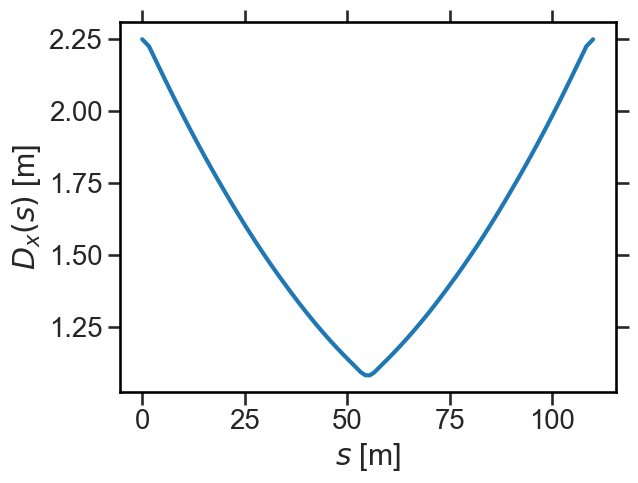

In [47]:
plt.plot(twiss['s'], twiss['dx'] * 0.999999991)
plt.xlabel('$s$ [m]')
plt.ylabel('$D_x(s)$ [m]');

$\implies$ Dispersion function $D(s)$ is focused by the quadrupoles in a similar way as the horizontal $\beta_x(s)$-function!

<h3>Dispersion effect in tracking</h3>

To illustrate the dispersion effect, we use the thin-lens tracking code `PySixTrack` (like our thin-lens betatron matrices but for 6D, i.e. including the momentum deviation $\delta$)!

We define a drift of $5$m length and a dipole with a bending angle of $0.1$ rad:

In [48]:
drift = elements.DriftExact(5)
dipole = elements.Multipole(knl=[0.1], hxl=0.1)

Initialize two particles, both at $x=0.04$m but only one at a momentum deviation of $\delta=10^{-3}$:

In [49]:
part0 = pysixtrack.Particles(x=0, delta=0)
part1 = pysixtrack.Particles(x=0, delta=0.001)

Track through the drift, then the dipole and again the drift:

In [50]:
rec_x0 = [part0.x]
rec_x1 = [part1.x]

drift.track(part0)
drift.track(part1)

rec_x0 += [part0.x]
rec_x1 += [part1.x]

dipole.track(part0)
dipole.track(part1)

rec_x0 += [part0.x]
rec_x1 += [part1.x]

drift.track(part0)
drift.track(part1)

rec_x0 += [part0.x]
rec_x1 += [part1.x]

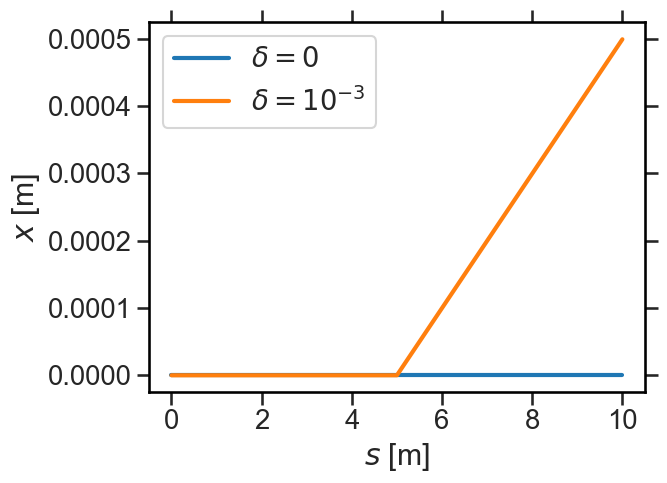

In [51]:
plt.plot([0, 5, 5, 10], rec_x0, label='$\delta=0$')
plt.plot([0, 5, 5, 10], rec_x1, label='$\delta=10^{-3}$')

plt.xlabel('$s$ [m]')
plt.ylabel('$x$ [m]')
plt.legend();

$\implies$ Bending at dipole position due to dispersion!

<h3>Chromaticity effect in tracking</h3>

Let us illustrate by tracking particles in `PySixTrack` again. We define a quadrupole with an integrated focusing strength of $k\cdot L=0.3$m$^{-1}$:

In [52]:
quad = elements.Multipole(knl = [0, 0.3])

Initialize two sets of particles with the same distribution in $x$, one of which features a momentum deviation of $\delta=0.1$:

In [53]:
npart = 11
x_dist = np.linspace(-0.05, 0.05, npart)

In [54]:
part0 = pysixtrack.Particles(x=x_dist.copy(), delta=0)
part1 = pysixtrack.Particles(x=x_dist.copy(), delta=0.1)

Track through the $5$m drift, then through the quadrupole and again through the same drift:

In [55]:
rec_x0 = [part0.x.copy()]
rec_x1 = [part1.x.copy()]

drift.track(part0)
drift.track(part1)

rec_x0 += [part0.x.copy()]
rec_x1 += [part1.x.copy()]

quad.track(part0)
quad.track(part1)

rec_x0 += [part0.x.copy()]
rec_x1 += [part1.x.copy()]

drift.track(part0)
drift.track(part1)

rec_x0 += [part0.x.copy()]
rec_x1 += [part1.x.copy()]

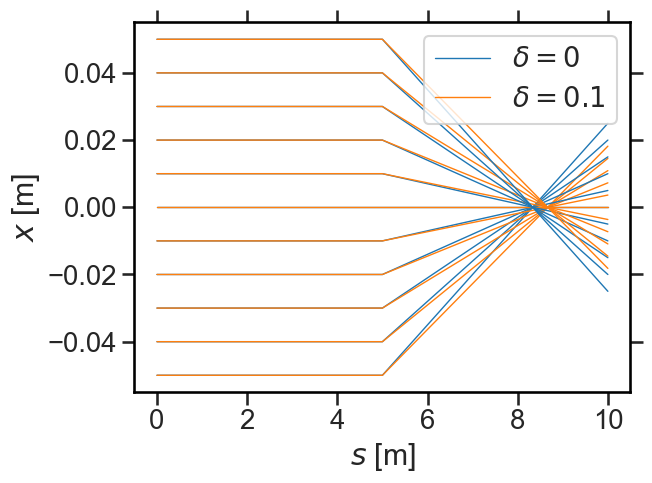

In [56]:
for i in range(npart):
    l0, = plt.plot([0, 5, 5, 10], np.array(rec_x0)[:, i], c='C0', lw=1)
    l1, = plt.plot([0, 5, 5, 10], np.array(rec_x1)[:, i], c='C1', lw=1)

plt.xlabel('$s$ [m]')
plt.ylabel('$x$ [m]')
plt.legend([l0, l1], ['$\delta=0$', '$\delta=0.1$']);

$\implies$ we observe less focusing for $/delta>0$ particles $\implies$ less phase advance in quasi-harmonic oscillation $\implies$ negative tune shift!

<h3>Natural chromaticity of a FODO cell</h3>

<h3>Chromatic detuning in a FODO cell from tracking</h3>

Let us track with `PySixTrack`through the LHC FODO cell for a distribution of particles with momentum spread and observe the chromatic tune shift.

We first define the same FODO cell as in `MAD-X` before (just in thin-lens approximation and without dipoles):

In [58]:
kL = 0.008 * 3.3

qf2_fodo = elements.Multipole(knl=[0, kL / 2.])
qd_fodo = elements.Multipole(knl=[0, -kL])
drift_fodo = elements.DriftExact(110 / 2.)

fodo = [qf2_fodo, drift_fodo, qd_fodo, drift_fodo, qf2_fodo]

We initialize a distribution of `npart` macro-particles, with a momentum spread between $\delta\in[-10^{-3},10^{-3}]$ at a fixed initial horizontal position of $x=0.04$m:

In [59]:
npart = 21
x_ini = 0.04
delta = np.linspace(-0.001, 0.001, npart)

particles = pysixtrack.Particles(x=x_ini, delta=delta)

We will record the $x$ position after each FODO cell for each particle:

In [60]:
ncells = 1024

rec_x = np.zeros((ncells, npart), dtype=float)
rec_x[0] = particles.x

Let's go for the tracking:

In [61]:
for i in range(1, ncells):
    for el in fodo:
        el.track(particles)
    rec_x[i] = particles.x

Comparing two particles with same initial $x$ but different $\delta$, we already see the different phase advance in the recorded horizontal motion:

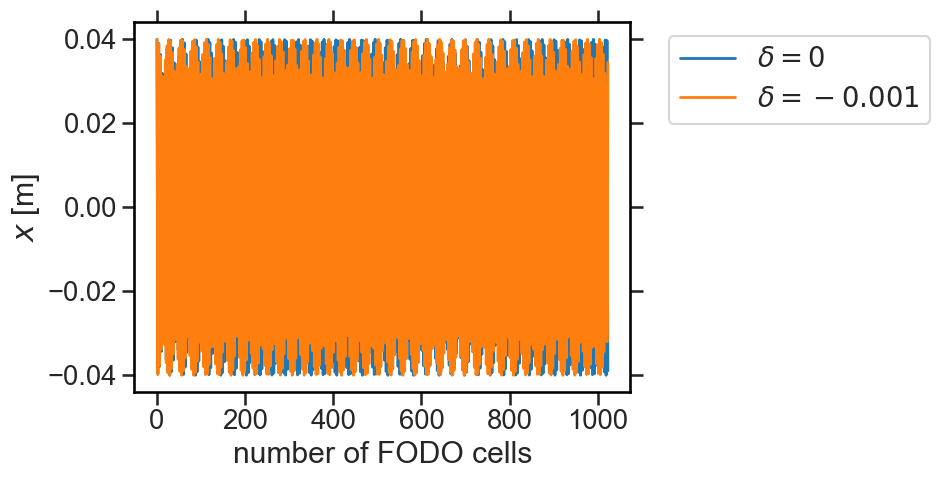

In [62]:
plt.plot(rec_x[:, npart//2 + 1], lw=2, label='$\delta=0$')
plt.plot(rec_x[:, 0], lw=2, label='$\delta=-0.001$')

plt.xlabel('number of FODO cells')
plt.ylabel('$x$ [m]')
plt.legend(bbox_to_anchor=(1.05, 1));

Let's evaluate the tune of each particle using the NAFF algorithm:

In [63]:
Qx_delta = np.zeros(npart, dtype=float)

for i in range(npart):
    Qx_delta[i] = PyNAFF.naff(rec_x[:, i], turns=ncells, nterms=1)[0, 1]

The tune of the $\delta=0$ particle should be the tune of the reference particle in this linear lattice:

In [64]:
Qx_delta[npart//2 + 1]

0.2585892190147644

In [65]:
qx_fodo

0.2518947018

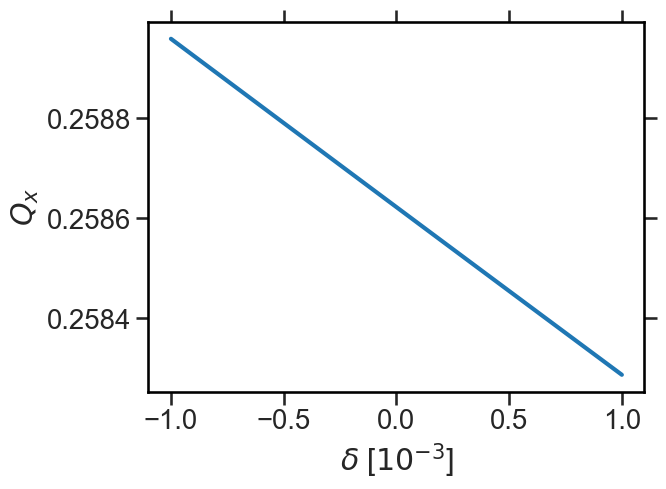

In [66]:
plt.plot(1e3 * delta, Qx_delta)

plt.xlabel('$\delta$ [$10^{-3}$]')
plt.ylabel('$Q_x$');

$\implies$ the tune changes with the momentum, as anticipated! The slope of this line is the first-order chromaticity $Q'_x$!

The `numpy` function `polyfit`is useful for a quick linear regression, the output is $(a,b)$ for $y=a\cdot x+b$:

In [67]:
np.polyfit(delta, Qx_delta, 1)

array([-0.3360318 ,  0.25862306])

The slope and thus the chromaticity of the LHC FODO cell is approximately $Q'_x=-0.3$, measured via particle tracking.

The analytical formula $Q'_{\mathrm{FODO}}=-\frac{1}{\pi}\tan\left(\frac{\Phi_{\mathrm{FODO}}}{2}\right)$ gives:

In [68]:
-1 / np.pi * np.tan(2 * np.pi * qx_fodo / 2)

-0.32212202611662033

`MAD-X`would have given us this value, too, we evaluated it as `twiss.summary['dq1'] * beta` (where `beta` is the speed of the particles):

In [69]:
qpx_fodo

-0.32209610180113507

<h3>Chromaticity correction in a FODO cell</h3>

For demonstration, we add sextupoles to the FODO lattice in `MAD-X`and compute their necessary strength.

Make sure that dipoles are switched on, the dipole angle `theta` should be non-zero:

In [70]:
madx.input('value, theta;')

theta              =     0.005099988074 ;


True

We add two sextupole magnets, one next to each quadrupole:

In [71]:
madx.input('sext1: sextupole, l = 1, k2 := k2sext1;')
madx.input('sext2: sextupole, l = 1, k2 := k2sext2;')
madx.command.seqedit(sequence='fodo')
madx.command.install(element='sext1', at=3.3/2 + 1)
madx.command.install(element='sext2', at=110/2 + 3.3/2 + 1)
madx.command.endedit()

++++++ info: seqedit - number of elements installed:  2
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0


True

In [72]:
madx.use('fodo')

In [73]:
madx.input(
'''match, sequence = fodo;
global, sequence = fodo, dq1 = {Qpx}, dq2 = {Qpy};
vary, name = k2sext1, step = 0.0001;
vary, name = k2sext2, step = 0.0001;
lmdif, tolerance = 1e-12;
endmatch;
'''.format(Qpx=0, Qpy=0))

START MATCHING

number of sequences: 1
sequence name: fodo
number of variables:    2
user given constraints: 2
total constraints:      2

START LMDIF:

Initial Penalty Function =   0.20718425E+00


call:       4   Penalty function =   0.11711009E-26
 ++++++++++ LMDIF ended: converged successfully
call:       4   Penalty function =   0.11711009E-26

MATCH SUMMARY

Node_Name                  Constraint   Type  Target Value       Final Value        Penalty
--------------------------------------------------------------------------------------------------
Global constraint:         dq1          4     0.00000000E+00     2.20777692E-14     4.87427893E-28
Global constraint:         dq2          4     0.00000000E+00    -2.61471410E-14     6.83672981E-28


Final Penalty Function =   1.17110087e-27





Variable                 Final Value  Initial Value Lower Limit  Upper Limit 
--------------------------------------------------------------------------------
k2sext1                   1.27667e-02

True

$\implies$ the iterative algorithm in `MAD-X` has found suitable values of the sextupole strengths `k2sext1` and `k2sext2` such that the target chromaticity has been corrected to 0.

In [74]:
twiss = madx.twiss();

twiss.summary.dq1

enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
               110                 -0    0.0004388874913        47.73351305 

                q1                dq1            betxmax              dxmax 
      0.2519723158     2.20777692e-14        186.8781443        2.249453549 

             dxrms             xcomax             xcorms                 q2 
       1.634424445                  0                  0       0.2518947018 

               dq2            betymax              dymax              dyrms 
  -2.614714098e-14        186.4581481                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            

2.20777692e-14

$\implies$ the chromaticity from the `MAD-X` optics computation has really become (numerically) zero!

We return to the `PySixTrack` tracking: after adding sextupoles of these strengths and the dipole magnets, we should be able to see the change via evaluating the chromaticity via NAFF from tracking data again!

As a short cut, we make the `MAD-X` lattice "thin" (apply thin-lens approximation) and transfer the lattice with dipoles and sextupoles to `PySixTrack`:

In [75]:
assert madx.command.select(
    flag='MAKETHIN',
    class_='quadrupole',
    slice_=1,
)

assert madx.command.select(
    flag='MAKETHIN',
    class_='sextupole',
    slice_=1,
)

assert madx.command.select(
    flag='MAKETHIN',
    class_='sbend',
    slice_=1,
)

madx.command.makethin(
    makedipedge=False,
    style='simple',
    sequence='fodo',
)

fodo_sext = pysixtrack.Line.from_madx_sequence(madx.sequence.fodo)

makethin: style chosen : simple
makethin: slicing sequence : fodo


Go about with the tracking again:

In [76]:
# define initial particle distribution & prepare recording array
particles = pysixtrack.Particles(x=x_ini, delta=delta)

rec_x = np.zeros((ncells, npart), dtype=float)
rec_x[0] = particles.x

In [77]:
# tracking!
for i in range(1, ncells):
    fodo_sext.track(particles)
    rec_x[i] = particles.x

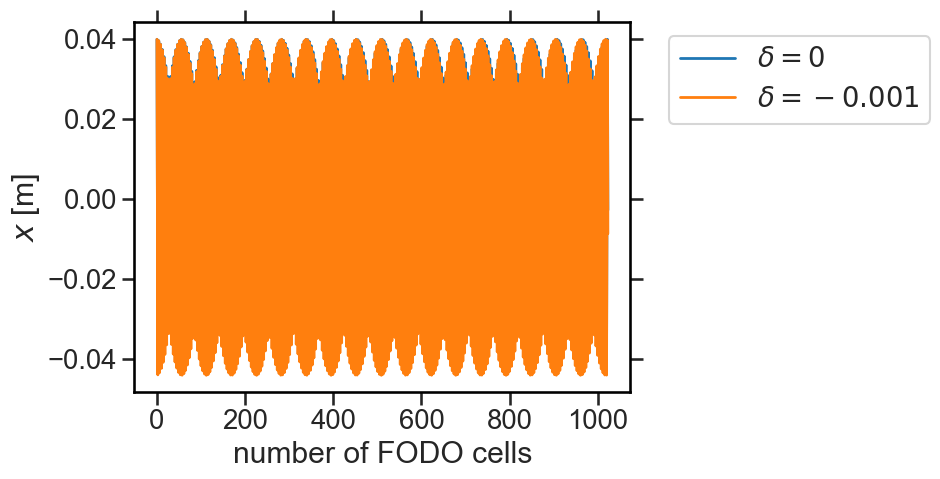

In [78]:
plt.plot(rec_x[:, npart//2 + 1], lw=2, label='$\delta=0$')
plt.plot(rec_x[:, 0], lw=2, label='$\delta=-0.001$')

plt.xlabel('number of FODO cells')
plt.ylabel('$x$ [m]')
plt.legend(bbox_to_anchor=(1.05, 1));

In [79]:
# evaluate tunes via NAFF
Qx_delta = np.zeros(npart, dtype=float)

for i in range(npart):
    Qx_delta[i] = PyNAFF.naff(rec_x[:, i], turns=ncells, nterms=1)[0, 1]

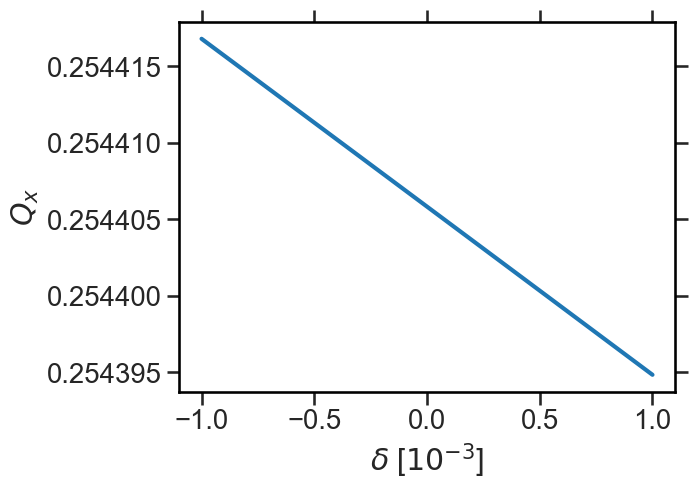

In [80]:
plt.plot(1e3 * delta, Qx_delta)

plt.xlabel('$\delta$ [$10^{-3}$]')
plt.ylabel('$Q_x$');

The fit for the now much flatter slope of the tune change with $\delta$ gives:

In [81]:
np.polyfit(delta, Qx_delta, 1)

array([-0.01098794,  0.25440583])

$\implies$ $Q'_x=-0.01$ is nearly zero, i.e. the chromaticity correction scheme works! (The remainders are due to the thin-lens approximation!)

<i>Hint: we have used 2 sextupoles as 2 degrees of freedom to correct both the horizontal and the vertical chromaticity to zero. One could use only one sextupole degree of freedom, but then only one of the transverse planes can be corrected to $Q'=0$, the other one likely increases!</i>